In [9]:
import praw
from psaw import PushshiftAPI
import datetime as dt
import pandas as pd
import text2emotion as te
import operator
import time
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

api = PushshiftAPI()

In [71]:
def getResultsByYear(year, api, subreddit):
    start_epoch = int(dt.datetime(year, 1, 1).timestamp())
    end_epoch = int(dt.datetime(year, 12, 31).timestamp())

    filterList = [
        'id',
        'title',
        'selftext',
        'subreddit',
        'num_comments',
        'score'
    ]

    return list(api.search_submissions(after=start_epoch,
                                before=end_epoch,
                                subreddit=subreddit,
                                filter=filterList,
                                sort='asc'))

def printBuckets(bucketList, year):
    bucket_num = 1
    for created_utc, bucket in bucketList:
        fileName = "data/" + subreddit + "/" + str(year) + "/Month" + str(bucket_num) + ".csv"
        bucket.to_csv(fileName, index=False)
        bucket_num += 1

def combine_dicts(dict1, dict2):
    return {key: dict1.get(key, 0) + dict2.get(key, 0)
          for key in set(dict1) | set(dict2)}

def creatEmotionSums(results_by_month_df):
    bucket_sums = []
    for reated_utc, bucket in result_by_month_df:
        bucket_sum = {'Angry': 0.0, 'Fear': 0.0, 'Happy': 0.0, 'Sad': 0.0, 'Surprise': 0.0}
        N = len(bucket)

        for index, entry in bucket.iterrows():
            emotion_tuple = te.get_emotion(str(entry.title) + " " + str(entry.selftext))
            if (sum(emotion_tuple.values()) > 0):
                # scale each tuple by the post score
                emotion_tuple.update({n: entry.score * emotion_tuple[n] for n in emotion_tuple.keys()})
                bucket_sum = combine_dicts(bucket_sum, emotion_tuple )

        bucket_sums.append(bucket_sum)
    
    return bucket_sums

In [65]:
# Start pulling years
def gatherData(subreddit, startYear, endYear):
    for year in range(startYear, endYear + 1):
        results_df = pd.DataFrame(getResultsByYear(year, api, subreddit))
        columnNames = results_df.columns

        results_df['created_utc'] = pd.to_datetime(results_df['created_utc'], origin='unix', unit='s')
        result_by_month_df = results_df.groupby(pd.Grouper(key='created_utc',freq='M'))

        # save final output to file
        printBuckets(result_by_month_df, year)

        # now we do some sentiment analysis on each bucket
        emotion_sums = creatEmotionSums(result_by_month_df)

        # convert dictionary list to csv
        emotion_df = pd.DataFrame(emotion_sums)
        normalized_emotion_df = emotion_df.div(emotion_df.sum(axis=1), axis=0)
        normalized_emotion_df.to_csv("data/" + str(subreddit) + "/" + str(year) + "/" + str(year) + "emotionAvgsOut.csv")
        print("Sleeping")
        time.sleep(60)

beginningYear = 2012
endingYear = 2021
subreddit = 'nonbinary'

Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
Sleeping
/Users/duquetr/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/Users/duquetr/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
Sleeping
/Users/duquetr/opt/anaconda3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
Sleeping
Sleeping
Sleeping


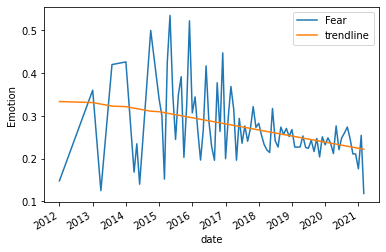

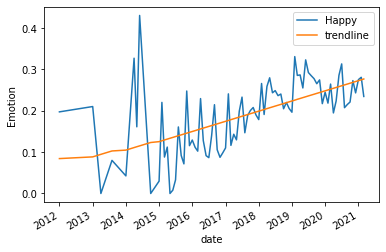

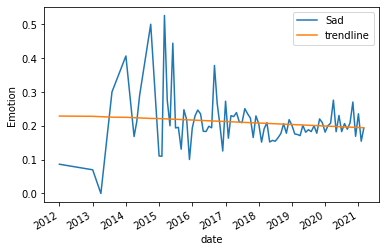

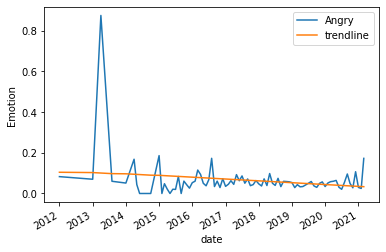

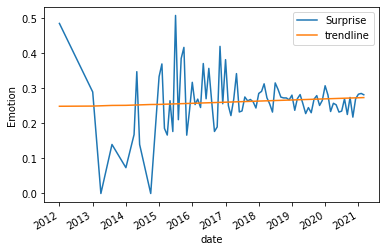

In [69]:
def saveDataframePlotToFile(df, columnName, subreddit):
    df.dropna(inplace=True)
    df["trendline"] = np.poly1d(np.polyfit(x=df.index, y=df[columnName], deg=1))(df.index)

    df.plot(x = "date", y=[columnName, "trendline"])

    outputFilename =  "data/" + subreddit + "/" + str(subreddit) + str(columnName) + "EmotionPlot.png"
    plt.xlabel("date")
    plt.ylabel("Emotion")
    plt.legend()

def combineEmotionCSVs(subreddit, startYear, endYear):
    # Combine Emotion csvs
    compiledEmotionOut = "data/" + subreddit + "/" + str(subreddit) + "CompiledEmotions.csv"
    li = []

    for year in range(startYear, endYear + 1):
        currentFile = "data/" + subreddit + "/" + str(year) + "/" + str(year) + "emotionAvgsOut.csv"
        df = pd.read_csv(currentFile, index_col=0, header=0)
        df['month_index'] = df.index + 1
        df['year'] = year
        df['date'] = pd.to_datetime(df.year*10000+df.month_index*100+1,format='%Y%m%d')
        li.append(df)

    combinedFrame = pd.concat(li, axis=0, ignore_index=True)
    combinedFrame.to_csv(compiledEmotionOut, index=True)

    return combinedFrame

def createPlots(subreddit, startYear, EndYear):
    combined_df = combineEmotionCSVs(subreddit, startYear, endYear)
    saveDataframePlotToFile(combined_df, "Fear", subreddit)
    saveDataframePlotToFile(combined_df, "Happy", subreddit)
    saveDataframePlotToFile(combined_df, "Sad", subreddit)
    saveDataframePlotToFile(combined_df, "Angry", subreddit)
    saveDataframePlotToFile(combined_df, "Surprise", subreddit)

# combine all of these different subreddits data into one for each month

In [16]:
# compile data from separate folders
def combineData(startYear, endYear):
    directoryNames = ["NonBinary", "trans"]
    for year in range(startYear, endYear + 1):
        for month in range(1, 13):
            pathList = []

            for folder in directoryNames:
                currentFile = "data/" + str(folder) + "/" + str(year) + "/Month" + str(month) + ".csv"
                print(currentFile)

                if Path(currentFile).is_file():
                    pathList.append(currentFile)

            outFile = "CompiledData/" + str(year) + "/Month" + str(month) + ".csv"

            if (len(pathList) > 1):
                combined_csv = pd.concat([pd.read_csv(f) for f in pathList], ignore_index=True)
                combined_csv.to_csv(outFile)

            elif (len(pathList) == 1):
                pd.read_csv(pathList[0]).to_csv(outFile)




data/NonBinary/2013/Month1.csv
data/trans/2013/Month1.csv
data/NonBinary/2013/Month2.csv
data/trans/2013/Month2.csv
data/NonBinary/2013/Month3.csv
data/trans/2013/Month3.csv
data/NonBinary/2013/Month4.csv
data/trans/2013/Month4.csv
data/NonBinary/2013/Month5.csv
data/trans/2013/Month5.csv
data/NonBinary/2013/Month6.csv
data/trans/2013/Month6.csv
data/NonBinary/2013/Month7.csv
data/trans/2013/Month7.csv
data/NonBinary/2013/Month8.csv
data/trans/2013/Month8.csv
data/NonBinary/2013/Month9.csv
data/trans/2013/Month9.csv
data/NonBinary/2013/Month10.csv
data/trans/2013/Month10.csv
data/NonBinary/2013/Month11.csv
data/trans/2013/Month11.csv
data/NonBinary/2013/Month12.csv
data/trans/2013/Month12.csv
data/NonBinary/2014/Month1.csv
data/trans/2014/Month1.csv
data/NonBinary/2014/Month2.csv
data/trans/2014/Month2.csv
data/NonBinary/2014/Month3.csv
data/trans/2014/Month3.csv
data/NonBinary/2014/Month4.csv
data/trans/2014/Month4.csv
data/NonBinary/2014/Month5.csv
data/trans/2014/Month5.csv
data/Non